# RNN - Model

In [28]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
# from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/Users/eduardomonteiro/code/mattwagon/oil_production_prediction/notebooks'

## Import the data

In [3]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = os.path.join('..', 'raw_data')
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

In [5]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


## Data cleaning

### Drop features with more than 30% NaN values

In [6]:
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)

In [7]:
df.shape

(5813, 65)

### Drop features with std = 0

In [8]:
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)

In [9]:
df.shape

(5813, 41)

### Drop corrected features

In [10]:
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)

### Drop choke features

In [11]:
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)

### Drop correlated features

In [12]:
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P', 'Qliq MPFM', 'Qwat MPFM']
df.drop(columns=features_corr_drop, inplace = True)

### Drop features in remove dictionary

In [13]:
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", "Downhole Gauge T", "Downhole Gauge P"}

In [14]:
df.drop(columns=remove, inplace=True)

## Impute features with <30% NaN values

In [15]:
for feature in df.columns:
    df[feature].replace(np.nan, df[feature].median(), inplace=True)

In [16]:
df.isnull().sum()

Date               0
WHT                0
WHP                0
Tubing Gradient    0
Service Line P     0
Sand Raw           0
Qoil MPFM          0
Qgas MPFM          0
MPFM WCT           0
MPFM Venturi dP    0
MPFM T             0
MPFM CF GOR        0
Manifold T         0
Manifold P         0
Jumper T           0
Choke Opening      0
Annulus P          0
dtype: int64

## Visualising the Time Series

In [17]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = 3 

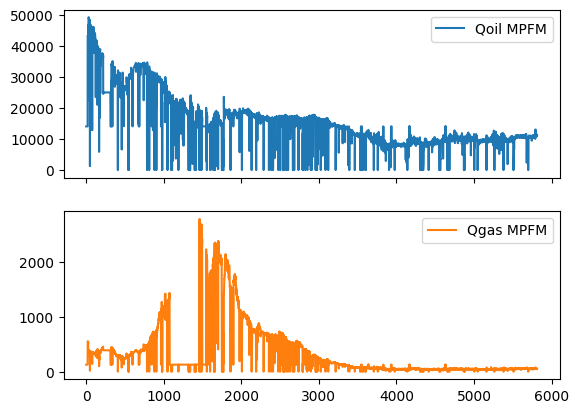

In [18]:
plot_cols = [TARGET, 'Qgas MPFM']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

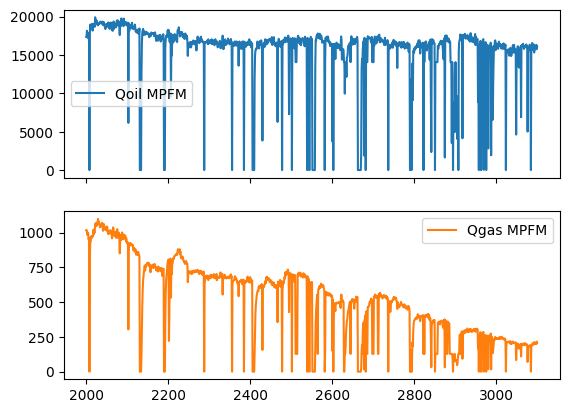

In [19]:
zoomed_slice = slice(2000,3100)

plot_features = df.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

## Prepare the dataset

### The big picture

Step 1: Cross validation in time series (folds):
    - we'll create folds and train/evaluate our LSTM on these different folds about the robustness of the neural network

Step 2: Holdout method within each fold (train-test-split) to:
    - fit the model on the train set;
    - and evaluate it on the test set;
    - always split the train set chronologically before the test set
    
Step 3: Sampling sequences in both the train set and the test set

### Creating folds for cross-validation

In [20]:
df_LSTM = df[['MPFM Venturi dP', 'WHT', 'Qoil MPFM']]
df_LSTM

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
5808,1687.935181,51.966740,10925.670806
5809,1719.284912,51.968021,11142.564473
5810,1742.380127,51.972717,11140.120568
5811,1729.632324,51.982071,11400.139595


In [21]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 365 * 6 # six years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 91 # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [22]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    fold_list = []
    
    
    for i in range(0, len(df), fold_stride):
        if i + fold_length >= len(df):
            break
        fold_list.append(df[i:fold_length])
    
    return fold_list

In [23]:
folds = get_folds(df_LSTM, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 40 folds.
Each fold has a shape equal to (2190, 3).


### Temporal Train/Test Split

Focus on 1 fold for the moment:

In [24]:
fold = folds[0]
fold

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
2185,4440.488770,50.234428,17033.866361
2186,4339.430664,50.448097,17049.719495
2187,4462.657715,50.312836,17144.442110
2188,4526.409668,50.242947,17705.125916


Split the fold above chronologically into a train dataframe and a test dataframe

In [25]:
INPUT_LENGTH = 14 #two weeks

In [26]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    fold_train = fold[0: round(train_test_ratio * len(fold))]
    fold_test = fold[round(train_test_ratio * len(fold)) - input_length:]
    
    return fold_train, fold_test

In [27]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

### Create (X,y) sequences

In [28]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 3
INPUT_LENGTH = 14 days = 2 weeks


In [29]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


In [30]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    random_number = np.random.randint(0,len(fold) - (input_length + output_length) + 1)

    X_i = fold.iloc[random_number : random_number + input_length]
    y_i = fold.iloc[random_number + input_length : random_number + input_length + output_length][[TARGET]]
    
    return (X_i, y_i)

In [31]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [32]:
# Advanced check 😈 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

In [33]:
X_train_i.shape

(14, 3)

### Scanning chronologically

Let's scan the fold with a temporal stride of 1 day (the minimum one)

In [34]:
SEQUENCE_STRIDE = 1

In [35]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [36]:
print("FOLD_LENGTH") 
print(f"= {int(FOLD_LENGTH)} days")
print(f"= {int(FOLD_LENGTH/7)} weeks")

FOLD_LENGTH
= 2190 days
= 312 weeks


In [37]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(1430, 14, 3)
(1430, 1, 1)


## Modeling

### LSTM

Create a function init_model which builds and compiles a simple Recurrent Neural Network with an LSTM layer

In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

#### Baseline model

In [42]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    model = models.Sequential()
    model.add(Lambda(lambda x: x[:, -1, 1, None]))
    
    adam = optimizers.Adam(learning_rate = 0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [43]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)} m3")

24/24 [==============================] - 0s 314us/step - loss: 276075424.0000 - mae: 15974.0498
- The Baseline MAE on the test set is equal to 15974.05 m3


2023-03-22 18:39:16.449186: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


#### Initial model from Weather prediction challenge but with batch_size=8 and epochs=150

In [44]:
def init_model(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(64, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [45]:
model_init = init_model(X_train, y_train)
model_init.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 3)          7         
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,480
Trainable params: 17,473
Non-trainable params: 7
_________________________________________________________________


In [46]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model: models, verbose=1) -> tuple[models, dict]:
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [47]:
model_init, history_init = fit_model(model_init)

Epoch 1/150
125/125 [==============================] - 1s 4ms/step - loss: 995914304.0000 - mae: 30738.6191 - val_loss: 365787008.0000 - val_mae: 17616.0566
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 987597056.0000 - mae: 30605.1953 - val_loss: 360920608.0000 - val_mae: 17504.1797
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 978200832.0000 - mae: 30454.7578 - val_loss: 355992000.0000 - val_mae: 17391.0195
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 968999360.0000 - mae: 30306.2988 - val_loss: 351088160.0000 - val_mae: 17275.3242
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 959917184.0000 - mae: 30159.0547 - val_loss: 346222336.0000 - val_mae: 17160.7754
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 950924928.0000 - mae: 30012.5273 - val_loss: 341432352.0000 - val_mae: 17047.0469
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 2ms/step - loss: 590305856.0000 - mae: 23389.2500 - val_loss: 160917296.0000 - val_mae: 11828.6914
Epoch 54/150
125/125 [==============================] - 0s 2ms/step - loss: 583754112.0000 - mae: 23251.4102 - val_loss: 157734256.0000 - val_mae: 11706.8340
Epoch 55/150
125/125 [==============================] - 0s 2ms/step - loss: 577246720.0000 - mae: 23113.6797 - val_loss: 154801488.0000 - val_mae: 11595.6113
Epoch 56/150
125/125 [==============================] - 0s 2ms/step - loss: 570783488.0000 - mae: 22976.0020 - val_loss: 151957408.0000 - val_mae: 11489.1650
Epoch 57/150
125/125 [==============================] - 0s 2ms/step - loss: 564363840.0000 - mae: 22838.4238 - val_loss: 149187168.0000 - val_mae: 11385.1221
Epoch 58/150
125/125 [==============================] - 0s 2ms/step - loss: 557987904.0000 - mae: 22700.9336 - val_loss: 146438384.0000 - val_mae: 11280.0547
Epoch 59/150
125/125 [==============================

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

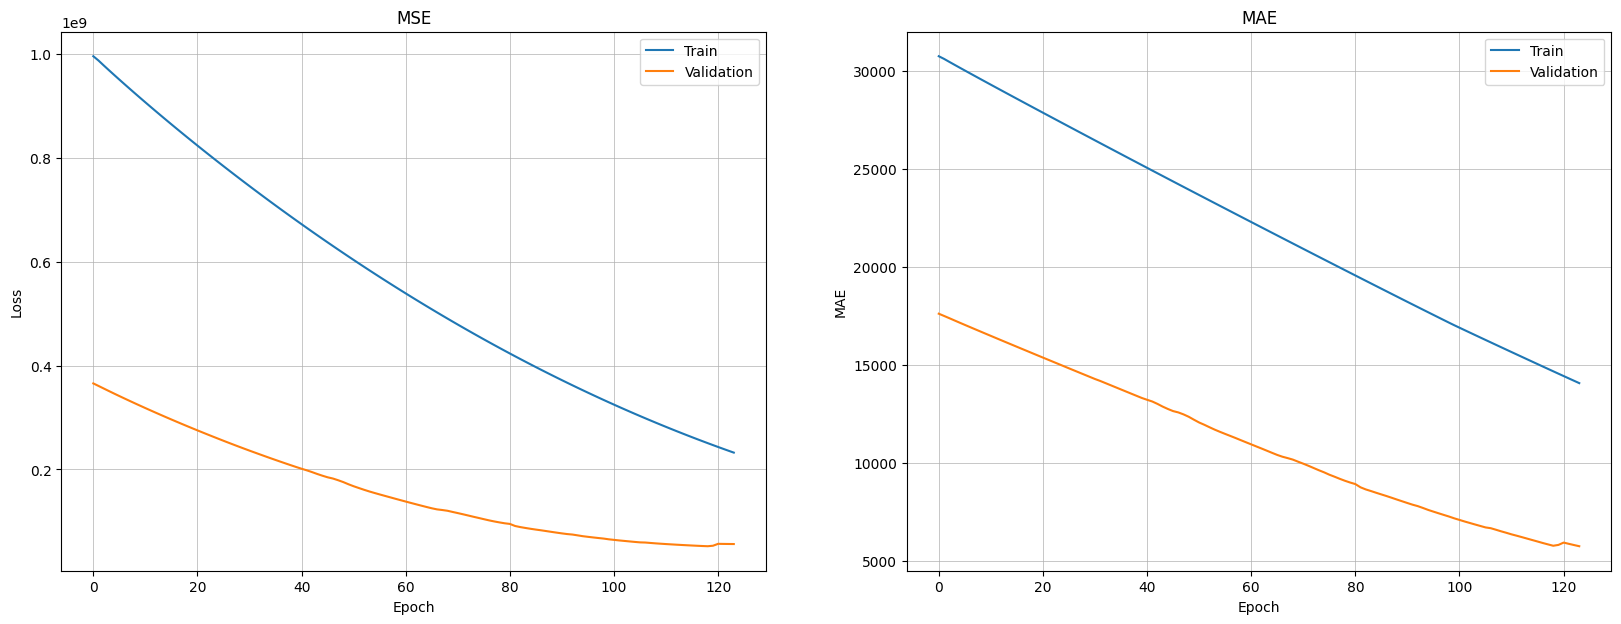

In [48]:
plot_history(history_init)

In [49]:
res = model_init.evaluate(X_test, y_test, verbose=0)
res

[21534168.0, 2683.525634765625]

In [50]:
mae_results = {}

In [51]:
mae_results['res'] = res[1]

#### Initial model with LSTM 128 neurons

In [52]:
def init_model_2(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [53]:
model_2 = init_model_2(X_train, y_train)
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,720
Trainable params: 67,713
Non-trainable params: 7
_________________________________________________________________


In [54]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [55]:
model_2, history_2 = fit_model(model_2)

Epoch 1/150
125/125 [==============================] - 1s 5ms/step - loss: 995156288.0000 - mae: 30726.2832 - val_loss: 369061408.0000 - val_mae: 17694.3457
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 989057920.0000 - mae: 30634.7598 - val_loss: 363064640.0000 - val_mae: 17557.5078
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 980935808.0000 - mae: 30497.6758 - val_loss: 355758784.0000 - val_mae: 17391.5820
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 969476160.0000 - mae: 30313.6016 - val_loss: 349794560.0000 - val_mae: 17254.6211
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 959392832.0000 - mae: 30150.3105 - val_loss: 344288192.0000 - val_mae: 17126.9316
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 949878848.0000 - mae: 29995.3203 - val_loss: 339039776.0000 - val_mae: 17004.0918
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 3ms/step - loss: 595354816.0000 - mae: 23494.9473 - val_loss: 159794512.0000 - val_mae: 11895.1807
Epoch 54/150
125/125 [==============================] - 0s 3ms/step - loss: 588857600.0000 - mae: 23358.9004 - val_loss: 156974320.0000 - val_mae: 11791.9414
Epoch 55/150
125/125 [==============================] - 0s 3ms/step - loss: 582405248.0000 - mae: 23222.9785 - val_loss: 154195360.0000 - val_mae: 11688.9033
Epoch 56/150
125/125 [==============================] - 0s 3ms/step - loss: 575996800.0000 - mae: 23087.1582 - val_loss: 151457632.0000 - val_mae: 11587.4619
Epoch 57/150
125/125 [==============================] - 0s 3ms/step - loss: 569632896.0000 - mae: 22951.4668 - val_loss: 148760944.0000 - val_mae: 11486.4229
Epoch 58/150
125/125 [==============================] - 0s 3ms/step - loss: 563313024.0000 - mae: 22815.8809 - val_loss: 146105200.0000 - val_mae: 11385.4658
Epoch 59/150
125/125 [==============================

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

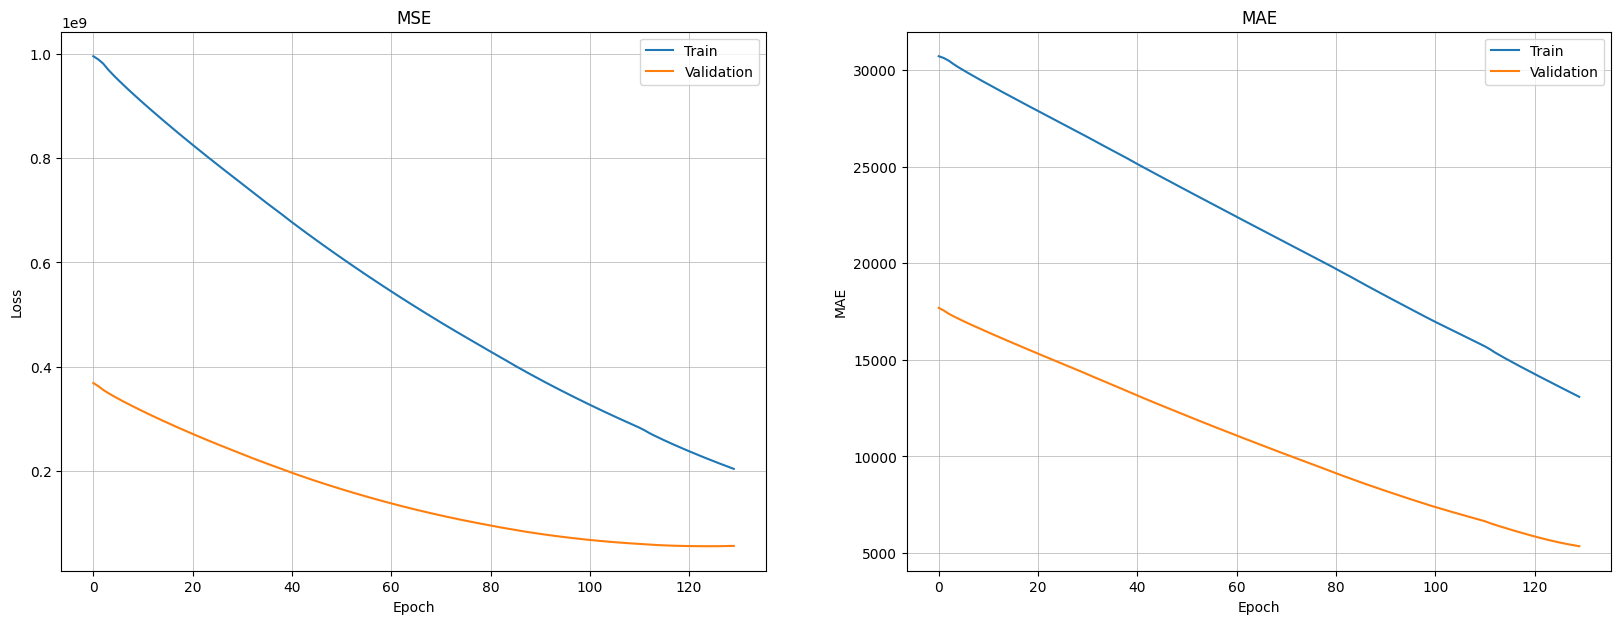

In [56]:
plot_history(history_2)

In [57]:
res2 = model_2.evaluate(X_test, y_test, verbose=0)
res2

[24139206.0, 2534.969482421875]

In [58]:
mae_results['res2'] = res2[1]

#### Initial model but with one more LSTM layer

In [59]:
def init_model_3(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.LSTM(64, activation='tanh'))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [60]:
model_3 = init_model_3(X_train, y_train)
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         67584     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 117,064
Trainable params: 117,057
Non-trainable params: 7
________________________________________________

In [61]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [62]:
model_3, history_3 = fit_model(model_3)

Epoch 1/150
125/125 [==============================] - 2s 9ms/step - loss: 996257088.0000 - mae: 30744.3574 - val_loss: 365776640.0000 - val_mae: 17618.6133
Epoch 2/150
125/125 [==============================] - 1s 6ms/step - loss: 987880256.0000 - mae: 30610.2227 - val_loss: 360705888.0000 - val_mae: 17504.1738
Epoch 3/150
125/125 [==============================] - 1s 6ms/step - loss: 979107200.0000 - mae: 30469.4629 - val_loss: 355745600.0000 - val_mae: 17391.3047
Epoch 4/150
125/125 [==============================] - 1s 6ms/step - loss: 970450816.0000 - mae: 30329.9043 - val_loss: 350850112.0000 - val_mae: 17278.9941
Epoch 5/150
125/125 [==============================] - 1s 6ms/step - loss: 961869760.0000 - mae: 30190.9082 - val_loss: 346010720.0000 - val_mae: 17167.0430
Epoch 6/150
125/125 [==============================] - 1s 6ms/step - loss: 953354944.0000 - mae: 30052.3301 - val_loss: 341224256.0000 - val_mae: 17055.3926
Epoch 7/150
125/125 [==============================] - 1s 

Epoch 53/150
125/125 [==============================] - 1s 6ms/step - loss: 607286016.0000 - mae: 23742.7969 - val_loss: 165082608.0000 - val_mae: 12085.0352
Epoch 54/150
125/125 [==============================] - 1s 6ms/step - loss: 600935360.0000 - mae: 23611.2715 - val_loss: 162285696.0000 - val_mae: 11985.2109
Epoch 55/150
125/125 [==============================] - 1s 6ms/step - loss: 594624960.0000 - mae: 23479.8262 - val_loss: 159526768.0000 - val_mae: 11885.4404
Epoch 56/150
125/125 [==============================] - 1s 6ms/step - loss: 588354240.0000 - mae: 23348.4414 - val_loss: 156805728.0000 - val_mae: 11785.7256
Epoch 57/150
125/125 [==============================] - 1s 6ms/step - loss: 582123392.0000 - mae: 23217.1426 - val_loss: 154122624.0000 - val_mae: 11686.2061
Epoch 58/150
125/125 [==============================] - 1s 6ms/step - loss: 575932672.0000 - mae: 23085.9199 - val_loss: 151477360.0000 - val_mae: 11588.1992
Epoch 59/150
125/125 [==============================

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

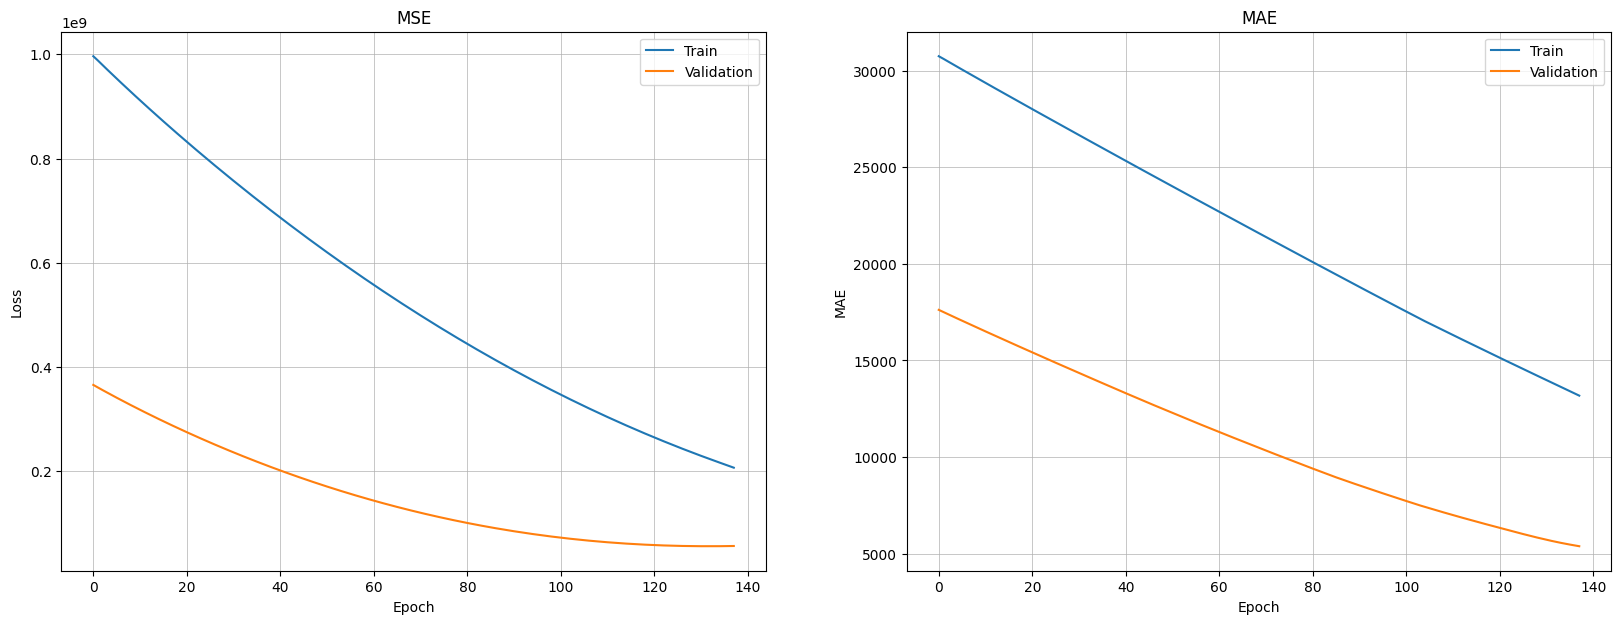

In [63]:
plot_history(history_3)

In [64]:
res3 = model_3.evaluate(X_test, y_test, verbose=0)
res3

[24067118.0, 2532.26953125]

In [65]:
mae_results['res3'] = res3[1]

In [66]:
print(mae_results)

{'res': 2683.525634765625, 'res2': 2534.969482421875, 'res3': 2532.26953125}


#### Add more layers

In [67]:
def init_model_4(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
    #model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.LSTM(64, activation='tanh'))
    #model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [68]:
model_4 = init_model_4(X_train, y_train)
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         67584     
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [69]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [70]:
model_4, history_4 = fit_model(model_4)

Epoch 1/150
125/125 [==============================] - 2s 10ms/step - loss: 996696384.0000 - mae: 30752.1035 - val_loss: 368433440.0000 - val_mae: 17678.4316
Epoch 2/150
125/125 [==============================] - 1s 6ms/step - loss: 991746240.0000 - mae: 30670.5547 - val_loss: 364055008.0000 - val_mae: 17580.3008
Epoch 3/150
125/125 [==============================] - 1s 6ms/step - loss: 984514624.0000 - mae: 30554.9434 - val_loss: 360502880.0000 - val_mae: 17500.1113
Epoch 4/150
125/125 [==============================] - 1s 6ms/step - loss: 977177088.0000 - mae: 30438.1973 - val_loss: 357074496.0000 - val_mae: 17422.3203
Epoch 5/150
125/125 [==============================] - 1s 6ms/step - loss: 970153920.0000 - mae: 30324.4551 - val_loss: 353515520.0000 - val_mae: 17341.0215
Epoch 6/150
125/125 [==============================] - 1s 6ms/step - loss: 962992320.0000 - mae: 30208.3691 - val_loss: 349805376.0000 - val_mae: 17255.6875
Epoch 7/150
125/125 [==============================] - 1s

Epoch 53/150
125/125 [==============================] - 1s 6ms/step - loss: 596156416.0000 - mae: 23506.7461 - val_loss: 189480240.0000 - val_mae: 12960.0430
Epoch 54/150
125/125 [==============================] - 1s 6ms/step - loss: 588868032.0000 - mae: 23357.4316 - val_loss: 186782560.0000 - val_mae: 12874.0078
Epoch 55/150
125/125 [==============================] - 1s 6ms/step - loss: 584070656.0000 - mae: 23257.7930 - val_loss: 184113664.0000 - val_mae: 12787.1504
Epoch 56/150
125/125 [==============================] - 1s 6ms/step - loss: 576258752.0000 - mae: 23089.4746 - val_loss: 181462704.0000 - val_mae: 12700.2080
Epoch 57/150
125/125 [==============================] - 1s 6ms/step - loss: 570511680.0000 - mae: 22966.7930 - val_loss: 178841280.0000 - val_mae: 12613.5439
Epoch 58/150
125/125 [==============================] - 1s 6ms/step - loss: 563674880.0000 - mae: 22826.1133 - val_loss: 176246320.0000 - val_mae: 12526.8213
Epoch 59/150
125/125 [==============================

Epoch 105/150
125/125 [==============================] - 1s 6ms/step - loss: 312801856.0000 - mae: 16554.3359 - val_loss: 85180064.0000 - val_mae: 8620.4072
Epoch 106/150
125/125 [==============================] - 1s 6ms/step - loss: 307942208.0000 - mae: 16417.6523 - val_loss: 83905672.0000 - val_mae: 8542.9648
Epoch 107/150
125/125 [==============================] - 1s 6ms/step - loss: 305090848.0000 - mae: 16328.7354 - val_loss: 82704120.0000 - val_mae: 8467.8555
Epoch 108/150
125/125 [==============================] - 1s 6ms/step - loss: 299282496.0000 - mae: 16163.0234 - val_loss: 81551656.0000 - val_mae: 8394.1074
Epoch 109/150
125/125 [==============================] - 1s 6ms/step - loss: 296044576.0000 - mae: 16055.6338 - val_loss: 80423472.0000 - val_mae: 8320.4736
Epoch 110/150
125/125 [==============================] - 1s 6ms/step - loss: 292048736.0000 - mae: 15948.3193 - val_loss: 79231792.0000 - val_mae: 8241.3730
Epoch 111/150
125/125 [==============================] - 1

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

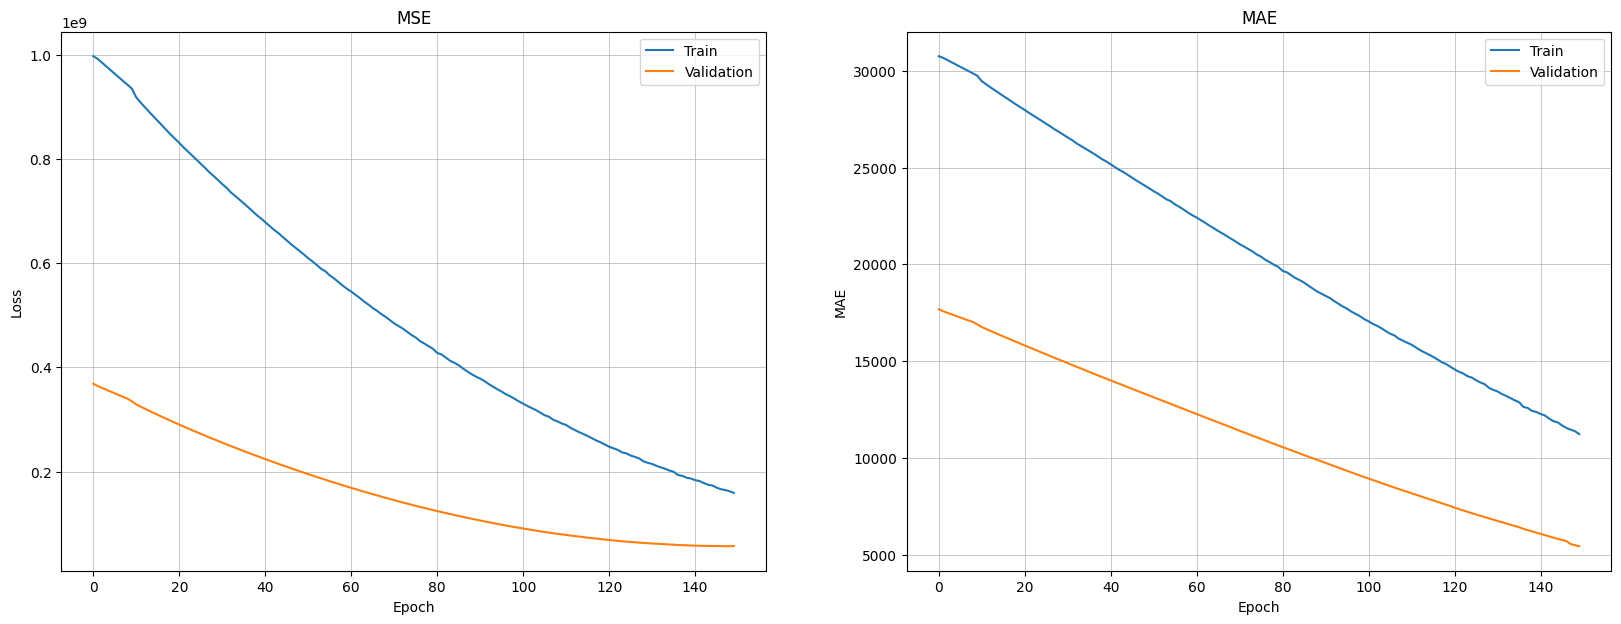

In [71]:
plot_history(history_4)

In [72]:
res4 = model_4.evaluate(X_test, y_test, verbose=0)
res4

[29043988.0, 3518.168701171875]

In [73]:
mae_results['res4'] = res4[1]

In [74]:
mae_results

{'res': 2683.525634765625,
 'res2': 2534.969482421875,
 'res3': 2532.26953125,
 'res4': 3518.168701171875}

#### Test with more features

In [202]:
df[['MPFM Venturi dP', 'WHT', 'Tubing Gradient']]

,MPFM Venturi dP,WHT,Tubing Gradient
0,1672.997986,51.247467,0.000000
1,1672.997986,51.247467,0.000000
2,1672.997986,51.247467,0.000000
3,1672.997986,51.247467,0.000000
4,1672.997986,51.247467,0.000000
...,...,...,...
5808,1687.935181,51.966740,1.003753
5809,1719.284912,51.968021,1.003906
5810,1742.380127,51.972717,1.005642
5811,1729.632324,51.982071,1.006597


In [296]:
def init_model_4(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.15)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [297]:
model_4 = init_model_4(X_train, y_train)
model_4.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_38 (Normaliza  (None, None, 3)          7         
 tion)                                                           
                                                                 
 lstm_50 (LSTM)              (None, 128)               67584     
                                                                 
 dense_37 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,720
Trainable params: 67,713
Non-trainable params: 7
_________________________________________________________________


In [298]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [299]:
model_4, history_4 = fit_model(model_4)

Epoch 1/150
125/125 [==============================] - 1s 5ms/step - loss: 964556736.0000 - mae: 30215.6406 - val_loss: 327854688.0000 - val_mae: 16739.6250
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 888815744.0000 - mae: 28958.2363 - val_loss: 287320896.0000 - val_mae: 15736.3643
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 816949440.0000 - mae: 27715.8789 - val_loss: 250696144.0000 - val_mae: 14758.2383
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 750925632.0000 - mae: 26525.0508 - val_loss: 222630672.0000 - val_mae: 13856.2500
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 685689728.0000 - mae: 25276.5391 - val_loss: 185955088.0000 - val_mae: 12695.2217
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 615159552.0000 - mae: 23872.2168 - val_loss: 155759152.0000 - val_mae: 11630.9375
Epoch 7/150
125/125 [==============================] - 0s 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

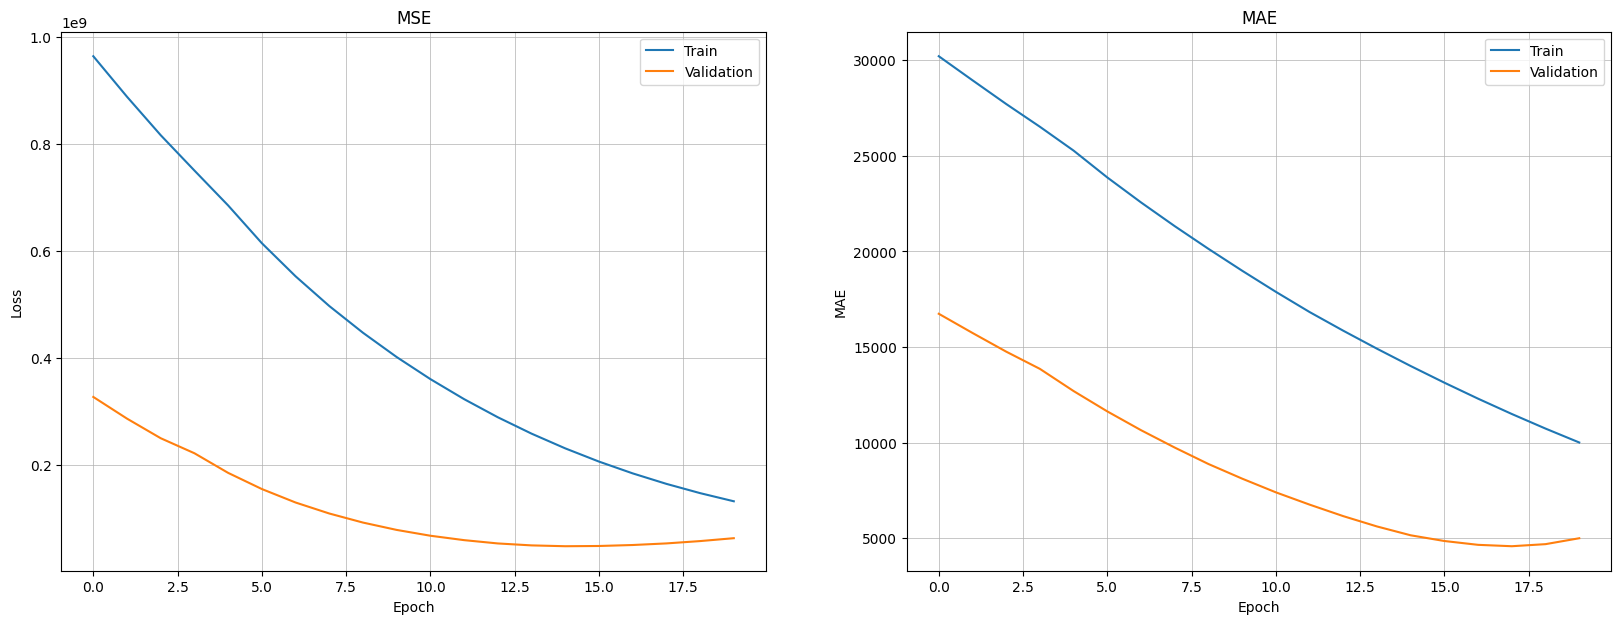

In [300]:
plot_history(history_4)

In [309]:
res4 = model_4.evaluate(X_test, y_test, verbose=0)
res4

[22892092.0, 2442.34619140625]

In [312]:
mae_results['res4'] = res4[1]

In [313]:
mae_results

{'res': 2532.921142578125,
 'res2': 2594.729736328125,
 'res3': 2493.5693359375,
 'res4': 2442.34619140625}

#### Applying a scaler to the df

In [565]:
FOLD_LENGTH

2190

In [566]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler.fit(df_LSTM)
df_LSTM_scaled = std_scaler.transform(df_LSTM)

In [567]:
df_LSTM_scaled = pd.DataFrame(df_LSTM_scaled, columns=df_LSTM.columns)

In [568]:
folds_longer = get_folds(df_LSTM_scaled, 365*3, FOLD_STRIDE)
fold_longer = folds_longer[0]
(fold_train_longer, fold_test_longer) = train_test_split(fold_longer, TRAIN_TEST_RATIO, INPUT_LENGTH)

X_train_c, y_train_c = get_X_y_strides(fold_train_longer, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test_c, y_test_c = get_X_y_strides(fold_test_longer, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train_c.shape)
print(y_train_c.shape)

(708, 14, 3)
(708, 1, 1)


In [569]:
N_FEATURES

3

In [559]:
def init_model_5(X_train, y_train):
    
    #normalization
    #normalizer = Normalization()
    #normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    #model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', input_shape=(X_train_c.shape[1], X_train_c.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [560]:
model_5 = init_model_5(X_train_c, y_train_c)
model_5.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_91 (LSTM)              (None, 128)               67584     
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_80 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [561]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor = "val_mae", mode = "min")

def fit_model(model):
    
    history = model.fit(X_train_c, y_train_c,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=250,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [562]:
model_5, history_5 = fit_model(model_5)

Epoch 1/250
62/62 [==============================] - 2s 7ms/step - loss: 0.9333 - mae: 0.6695 - val_loss: 0.6518 - val_mae: 0.7323
Epoch 2/250
62/62 [==============================] - 0s 4ms/step - loss: 1.0010 - mae: 0.7356 - val_loss: 0.3131 - val_mae: 0.4198
Epoch 3/250
62/62 [==============================] - 0s 4ms/step - loss: 0.9121 - mae: 0.7171 - val_loss: 0.3013 - val_mae: 0.3857
Epoch 4/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8924 - mae: 0.7198 - val_loss: 0.3543 - val_mae: 0.4467
Epoch 5/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8647 - mae: 0.6832 - val_loss: 0.2928 - val_mae: 0.3871
Epoch 6/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8888 - mae: 0.6834 - val_loss: 0.3434 - val_mae: 0.4574
Epoch 7/250
62/62 [==============================] - 0s 4ms/step - loss: 0.7312 - mae: 0.6160 - val_loss: 0.5694 - val_mae: 0.6840
Epoch 8/250
62/62 [==============================] - 0s 4ms/step - loss: 0.9909 - m

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

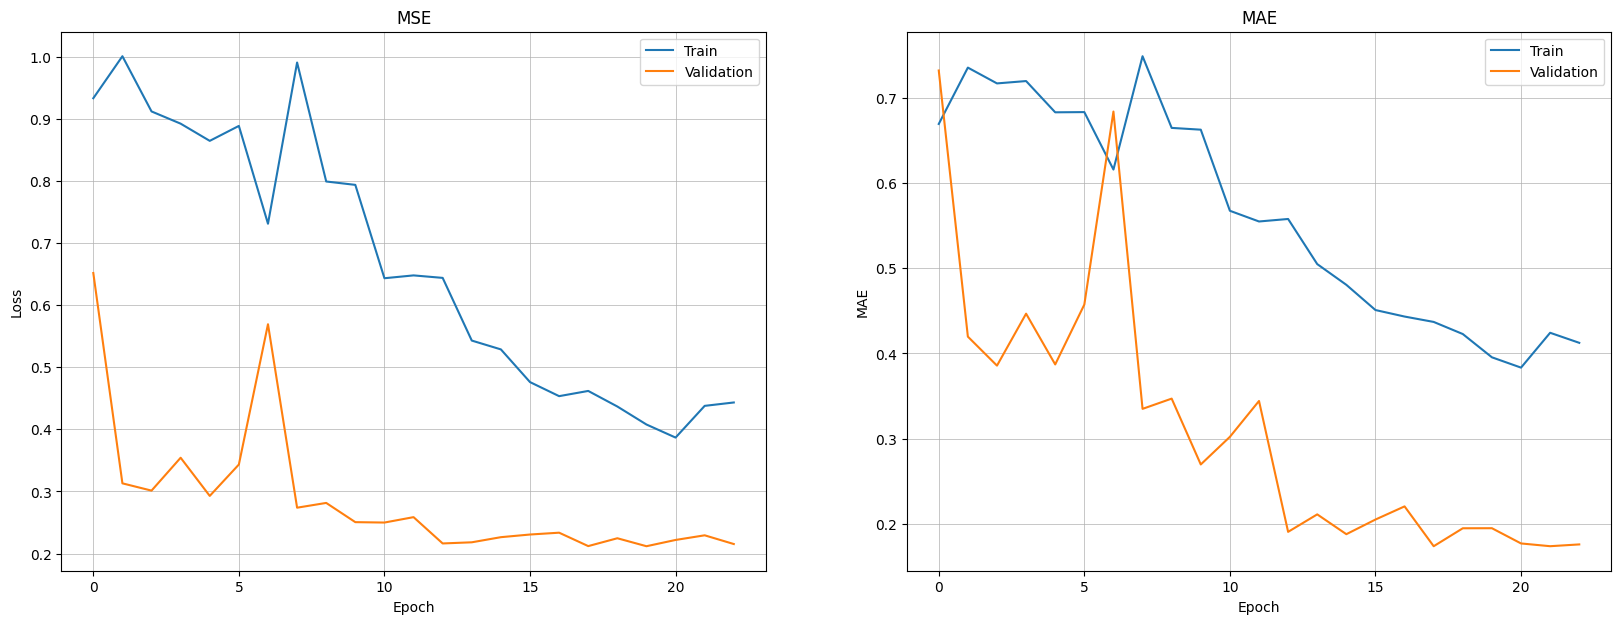

In [563]:
plot_history(history_5)

In [564]:
res5 = model_5.evaluate(X_test_c, y_test_c, verbose=0)
res5

[0.5426031947135925, 0.49569591879844666]

In [550]:
predicted_values = pd.DataFrame(model_5.predict(X_test_c))


12/12 [==============================] - 0s 989us/step


In [552]:
pd.DataFrame(y_test_c)

ValueError: Must pass 2-d input. shape=(371, 1, 1)

### Ben's code

In [280]:
train_start_date = pd.to_datetime('2007-02-01')
train_end_date = pd.to_datetime('2019-12-31')
test_start_date = pd.to_datetime('2020-01-01')
test_end_date = pd.to_datetime('2022-12-31')


df_train = df[(df['Date']>=train_start_date) & (df['Date']<=train_end_date)]
df_test = df[(df['Date']>=test_start_date) & (df['Date']<=test_end_date)]

In [282]:
def subsample_sequence(sequence, length, horizon):

    # Bounds of sampling
    last_possible = len(sequence) - length - horizon
    random_start = np.random.randint(0, last_possible)

    # Sample
    X = sequence.iloc[random_start:random_start + length, :].drop(columns=['Date'])
    #[random_start:random_start +length].drop(columns=['Date','Qoil MPFM']) 
    y = sequence.iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #loc[random_start+length+horizon-1]['Qoil MPFM']

    return X, y


subsample_sequence(df, 3, 1)

(            WHT        WHP  Tubing Gradient  Service Line P     Sand Raw  \
 1005  49.315823  83.868332          0.75049      104.703743  4816.931641   
 1006  49.311733  83.551620          0.75334      103.534454  4817.323730   
 1007  49.268120  82.987663          0.75488      104.737839  4823.788086   
 
          Qoil MPFM    Qgas MPFM   MPFM WCT  MPFM Venturi dP     MPFM T  \
 1005  27401.230468  1115.577469  15.119910           5000.0  49.045624   
 1006  27323.854739  1099.430625  15.274095           5000.0  49.053574   
 1007  27960.182118  1119.347813  15.670171           5000.0  49.012070   
 
       MPFM CF GOR  Manifold T  Manifold P   Jumper T  Choke Opening  \
 1005          1.0   48.938625   64.620178  47.114628      80.277328   
 1006          1.0   48.889065   64.216125  47.094799      80.141037   
 1007          1.0   48.924419   64.546654  47.053577      81.391449   
 
        Annulus P  
 1005  109.776886  
 1006  109.744576  
 1007  109.602852  ,
 1008    28188.12

In [283]:
def get_X_y(sequence, length, horizon, number_of_samples):
    
    X, y = [], []
    
    # Do as many samples as specified
    for sample in range(1,number_of_samples + 1):
    
        # Record sample X & y
        xi, yi = subsample_sequence(sequence, length, horizon)
        X.append(np.array(xi.values.T.tolist()).T) # Getting the right shape (sequences, observations,features)
        y.append(yi)

    return np.array(X), np.array(y)

In [284]:
X_train, y_train = get_X_y(sequence=df_train,
               length=500,
               horizon=1,
               number_of_samples=5000)

In [285]:
X_test, y_test = get_X_y(sequence=df_test,
               length=500,
               horizon=1,
               number_of_samples=1000)

In [286]:
X_test.shape

(1000, 500, 16)

#### LSTM with batch normalization

In [273]:
def init_model_6(X_train, y_train):
    
    #normalization
    #normalizer = Normalization(axis=-1)
    #normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(normalizer)
    model.add(layers.LSTM(32, activation='tanh'))
    model.add(layers.Dropout(rate=0.2))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [274]:
model_6 = init_model_6(X_train, y_train)
model_6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 500, 15)          60        
 hNormalization)                                                 
                                                                 
 lstm_14 (LSTM)              (None, 32)                6144      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,237
Trainable params: 6,207
Non-trainable params: 30
_________________________________________________________________


In [275]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [276]:
model_6, history_6 = fit_model(model_6)

Epoch 1/50
110/110 [==============================] - 9s 73ms/step - loss: 293840384.0000 - mae: 15290.3096 - val_loss: 292420832.0000 - val_mae: 15307.8174
Epoch 2/50
110/110 [==============================] - 8s 70ms/step - loss: 288244960.0000 - mae: 15126.4375 - val_loss: 286907008.0000 - val_mae: 15145.2080
Epoch 3/50
110/110 [==============================] - 8s 70ms/step - loss: 282826048.0000 - mae: 14966.1279 - val_loss: 281524256.0000 - val_mae: 14984.8691
Epoch 4/50
110/110 [==============================] - 8s 70ms/step - loss: 277571840.0000 - mae: 14808.6328 - val_loss: 276256384.0000 - val_mae: 14826.0645
Epoch 5/50
110/110 [==============================] - 8s 71ms/step - loss: 272340960.0000 - mae: 14651.2021 - val_loss: 271077280.0000 - val_mae: 14668.0449
Epoch 6/50
110/110 [==============================] - 8s 71ms/step - loss: 267258000.0000 - mae: 14492.4492 - val_loss: 265999520.0000 - val_mae: 14511.2441
Epoch 7/50
110/110 [==============================] - 8s 7

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

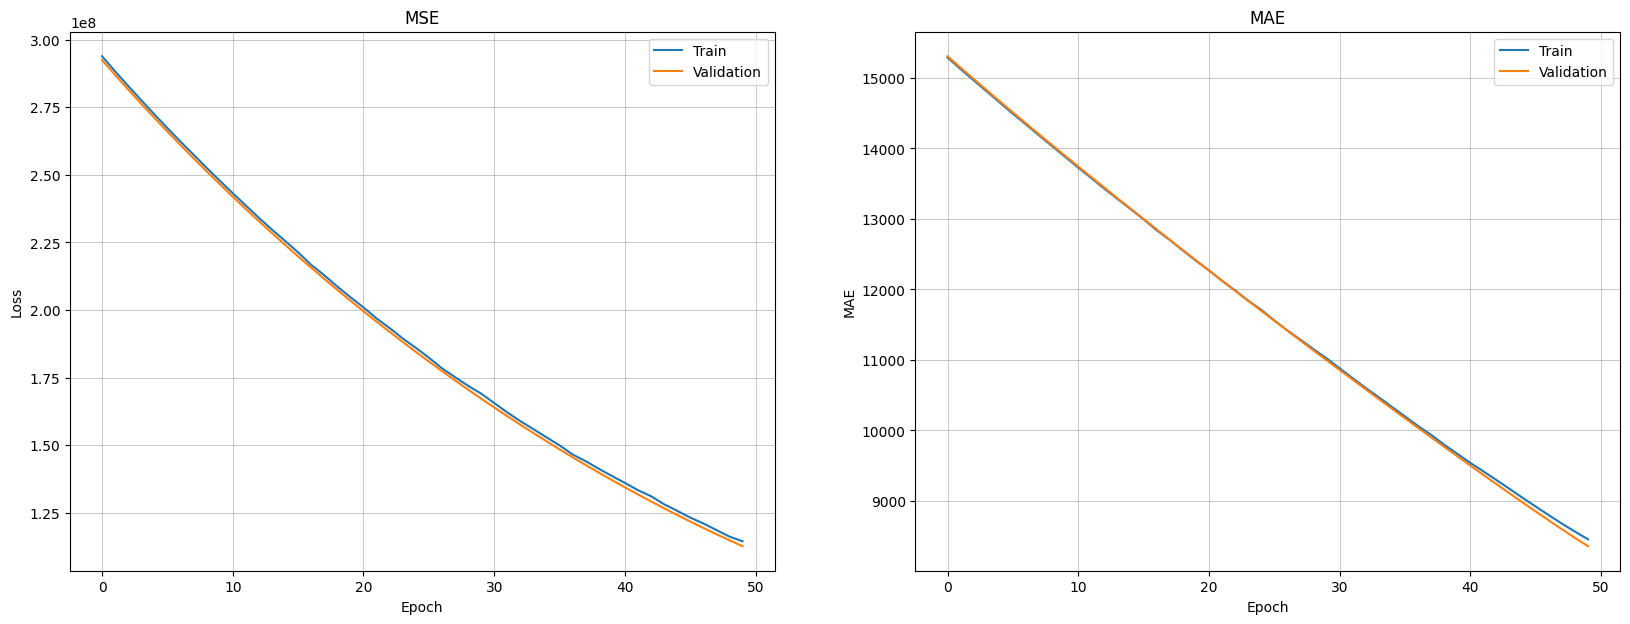

In [277]:
plot_history(history_6)

In [278]:
res6 = model_6.evaluate(X_test, y_test, verbose=0)
res6

[7056731.5, 2440.384033203125]

In [280]:
y_test

array([[10389.04368363],
       [11012.5664764 ],
       [11446.32501791],
       [10896.44069149],
       [ 9929.39610592],
       [10578.55110606],
       [ 9203.35427311],
       [ 9864.26984503],
       [10409.7915366 ],
       [ 9794.58976729],
       [10492.55145704],
       [    0.        ],
       [10477.12905908],
       [10389.04368363],
       [ 9120.1106392 ],
       [10171.86554704],
       [10268.6946194 ],
       [10285.43916752],
       [10653.16851633],
       [11185.20727064],
       [ 9924.05107202],
       [11400.13959466],
       [11204.69977197],
       [10457.96824699],
       [ 1923.87245153],
       [ 9801.12796109],
       [11142.56447274],
       [10730.57073419],
       [10741.84010645],
       [10823.42759757],
       [10217.28048383],
       [ 9430.06847534],
       [ 6427.02377554],
       [    0.        ],
       [10544.19247726],
       [10142.66998374],
       [10621.72483708],
       [10850.52937254],
       [10448.40338887],
       [10325.07257659],


In [282]:
y_pred.shape

(1000, 1)

In [279]:
y_pred = model_6.predict(X_test)
y_pred

32/32 [==============================] - 1s 13ms/step


array([[8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],


In [72]:
def plot_predictions(y_test, y_pred):
    #y_test2 = y_test.reshape((y_test.shape[0], y_test.shape[1]))
    plt.plot(y_test, color='red', label='real')
    plt.plot(y_pred, color='blue', label='predicted')
    plt.legend()
    plt.show()

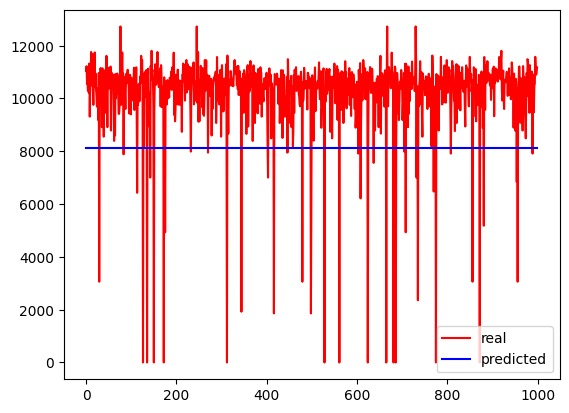

In [154]:
plot_predictions(y_test, y_pred)

#### LSTM with MinMaxScaler:

Scale the data

In [106]:
#scaler_X = MinMaxScaler(feature_range=(0,1))
#X_train_scaled = pd.DataFrame(scaler_X.fit_transform(df_train.drop(columns='Date')), columns=df_train.drop(columns='Date').columns)
#X_test_scaled = pd.DataFrame(scaler_X.transform(df_test.drop(columns='Date')), columns=df_test.drop(columns='Date').columns)

#scaler_y = MinMaxScaler(feature_range=(0,1))
#y_train_scaled = pd.DataFrame(scaler_y.fit_transform(df_test['Qoil MPFM'].values.reshape(-1,1)), columns=['Qoil MPFM'])
#y_test_scaled = pd.DataFrame(scaler_y.transform(df_test['Qoil MPFM'].values.reshape(-1,1)), columns=['Qoil MPFM'])

In [47]:
y_train_scaled

,Qoil MPFM
0,0.734702
1,0.807918
2,0.779226
3,0.829883
4,0.758747
...,...
1091,0.834971
1092,0.851547
1093,0.851360
1094,0.871231


In [149]:
def subsample_sequence(sequence, length, horizon):

    # Bounds of sampling
    last_possible = len(sequence) - length - horizon
    random_start = np.random.randint(0, last_possible)

    # Sample
    X = sequence.iloc[random_start:random_start + length, :].drop(columns=['Date'])
    #iloc[random_start:random_start + length, :] 
    #[random_start:random_start +length].drop(columns=['Date','Qoil MPFM']) 
    y = sequence.iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #loc[random_start+length+horizon-1]['Qoil MPFM']

    return X, y


subsample_sequence(df_train, 3, 1)

(            WHT        WHP  Tubing Gradient  Service Line P     Sand Raw  \
 3700  51.014294  75.868973         0.960590      125.373924  4832.000000   
 3701  50.509808  72.150963         0.973866      126.708061  4808.083008   
 3702  50.884972  72.686890         0.966274      126.222870  4847.974609   
 
          Qoil MPFM  Qgas MPFM   MPFM WCT  MPFM Venturi dP     MPFM T  \
 3700   8828.836812  57.001383  57.546173       768.758972  52.683151   
 3701   9837.369617  63.908660  57.049984       930.635376  52.715641   
 3702  10163.357948  74.877721  56.039120       893.420593  52.704643   
 
       MPFM CF GOR  Manifold T  Manifold P   Jumper T  Choke Opening  \
 3700          1.0   52.912804   69.967026  51.030762      69.567024   
 3701          1.0   52.636478   62.012146  51.042225      67.033012   
 3702          1.0   53.004265   62.545902  51.346462      67.229301   
 
        Annulus P  
 3700  164.157455  
 3701  163.880936  
 3702  163.969925  ,
 3703    9480.814626
 Nam

In [150]:
def get_X_y(sequence, length, horizon, number_of_samples):
    
    X, y = [], []
    
    # Do as many samples as specified
    for sample in range(1,number_of_samples + 1):
    
        # Record sample X & y
        xi, yi = subsample_sequence(sequence, length, horizon)
        X.append(np.array(xi.values.T.tolist()).T) # Getting the right shape (sequences, observations,features)
        y.append(yi)

    return np.array(X), np.array(y)

In [151]:
X_train, y_train = get_X_y(sequence=df_train,
               length=500,
               horizon=1,
               number_of_samples=5000)

In [153]:
X_test, y_test = get_X_y(sequence=df_test,
               length=500,
               horizon=1,
               number_of_samples=1000)

In [154]:
y_train.shape

(5000, 1)

In [155]:
X_test.shape

(1000, 500, 16)

In [146]:
falar = X_train.reshape(X_train.shape[0], -1)
falar.shape

(5000, 8000)

In [287]:
scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))
X_train = scaler_X.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler_X.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1,y_train.shape[-1])).reshape(y_train.shape)
y_test = scaler_y.transform(y_test.reshape(-1,y_test.shape[1])).reshape(y_test.shape)

In [288]:
def init_model_7(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    #model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(normalizer)
    model.add(layers.LSTM(16, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.2))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [289]:
model_7 = init_model_7(X_train, y_train)
model_7.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 16)                2112      
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,129
Trainable params: 2,129
Non-trainable params: 0
_________________________________________________________________


In [290]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [291]:
model_7, history_7 = fit_model(model_7)

Epoch 1/50
110/110 [==============================] - 6s 49ms/step - loss: 0.1047 - mae: 0.2137 - val_loss: 0.0330 - val_mae: 0.1293
Epoch 2/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0270 - mae: 0.1153 - val_loss: 0.0178 - val_mae: 0.1010
Epoch 3/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0191 - mae: 0.0940 - val_loss: 0.0154 - val_mae: 0.0903
Epoch 4/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0165 - mae: 0.0847 - val_loss: 0.0158 - val_mae: 0.0922
Epoch 5/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0152 - mae: 0.0794 - val_loss: 0.0152 - val_mae: 0.0874
Epoch 6/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0148 - mae: 0.0755 - val_loss: 0.0136 - val_mae: 0.0789
Epoch 7/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0154 - mae: 0.0768 - val_loss: 0.0147 - val_mae: 0.0906
Epoch 8/50
110/110 [==============================] - 5s 47ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

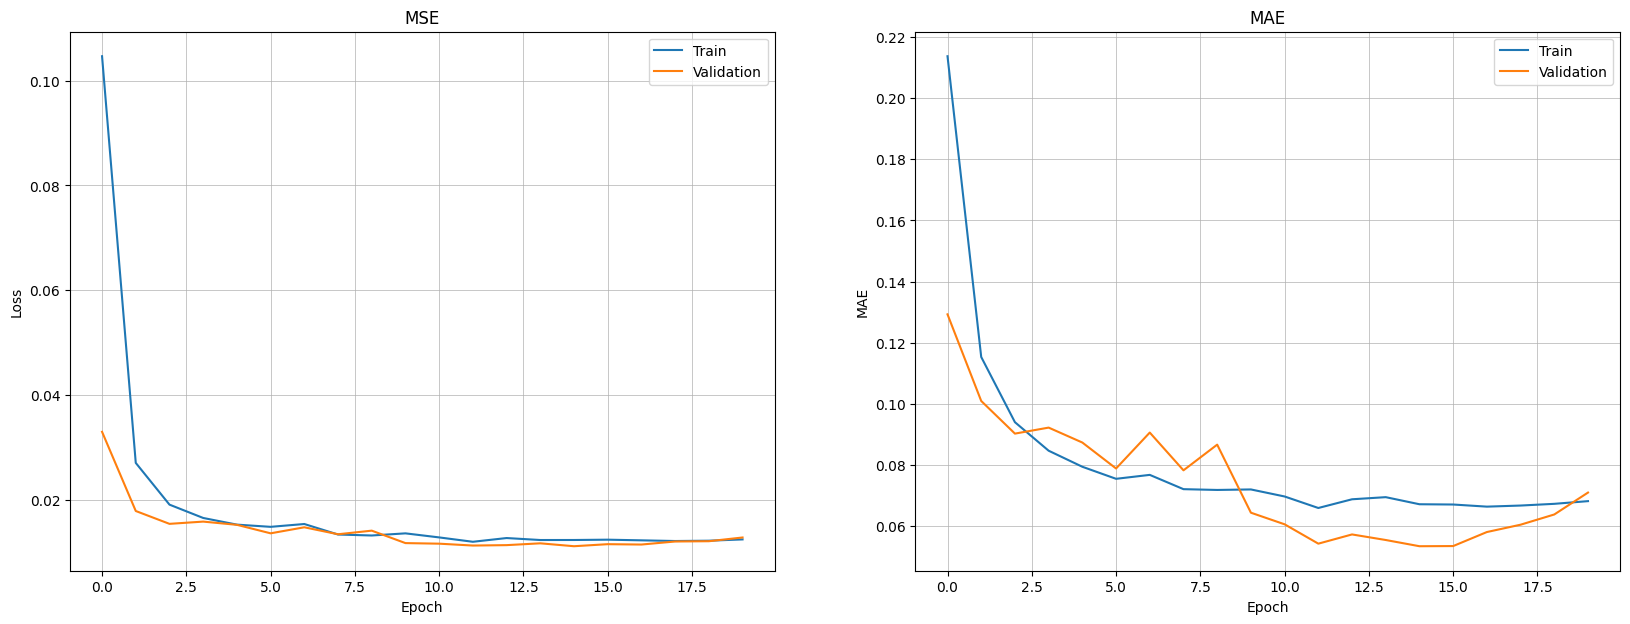

In [292]:
plot_history(history_7)

In [293]:
res7 = model_7.evaluate(X_test, y_test, verbose=0)
res7

[0.0019799547735601664, 0.025816407054662704]

In [294]:
y_pred = model_7.predict(X_test)
y_pred

32/32 [==============================] - 1s 9ms/step


array([[ 0.28196076],
       [ 0.29812217],
       [ 0.28294295],
       [ 0.29077137],
       [ 0.26993972],
       [ 0.24927503],
       [ 0.22617301],
       [ 0.31197178],
       [ 0.29910427],
       [ 0.2918513 ],
       [ 0.27138418],
       [ 0.2673119 ],
       [ 0.2504994 ],
       [ 0.29355294],
       [ 0.29278767],
       [ 0.20323816],
       [ 0.32087928],
       [ 0.30935913],
       [ 0.2782855 ],
       [ 0.29455215],
       [ 0.27066582],
       [ 0.2783767 ],
       [ 0.30219942],
       [ 0.29868263],
       [-0.02131826],
       [ 0.26711163],
       [ 0.29371718],
       [ 0.27196229],
       [ 0.30086872],
       [ 0.30425668],
       [ 0.28056738],
       [ 0.2999573 ],
       [ 0.29236633],
       [ 0.2999573 ],
       [ 0.27775505],
       [ 0.28456149],
       [ 0.3007047 ],
       [ 0.27098706],
       [ 0.29487953],
       [ 0.30455202],
       [ 0.29679212],
       [ 0.28234816],
       [ 0.24013631],
       [ 0.29628634],
       [ 0.27072856],
       [ 0

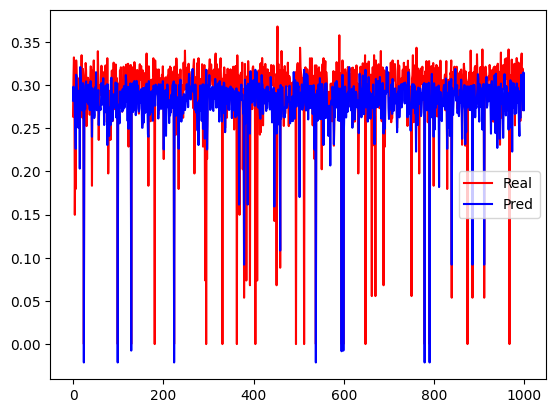

In [295]:
plt.plot(y_test, c='red', label='Real')
plt.plot(y_pred, c='blue', label='Pred')
plt.legend()
plt.show()

In [296]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_unscaled = scaler_y.inverse_transform(y_pred)

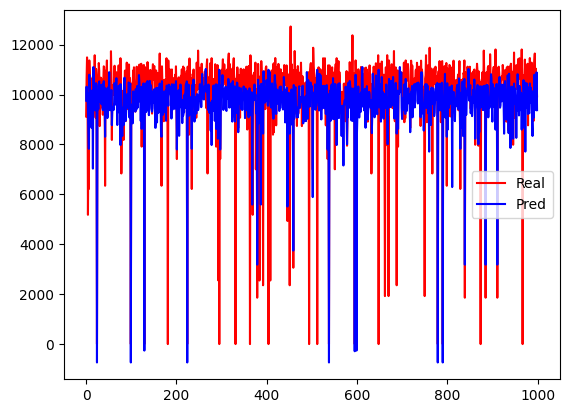

In [297]:
plt.plot(y_test_unscaled, c='red', label='Real')
plt.plot(y_pred_unscaled, c='blue', label='Pred')
plt.legend()
plt.show()

#### Second LSTM with MinMaxScaler

In [308]:
def init_model_8(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    #model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(normalizer)
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.2))
    #model.add(layers.LSTM(8, activation='tanh'))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [309]:
model_8 = init_model_8(X_train, y_train)
model_8.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 8)                 800       
                                                                 
 dropout_15 (Dropout)        (None, 8)                 0         
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [310]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [311]:
model_8, history_8 = fit_model(model_8)

Epoch 1/50
125/125 [==============================] - 4s 28ms/step - loss: 0.0543 - mae: 0.1577 - val_loss: 0.0201 - val_mae: 0.1029
Epoch 2/50
125/125 [==============================] - 3s 27ms/step - loss: 0.0218 - mae: 0.0961 - val_loss: 0.0143 - val_mae: 0.0776
Epoch 3/50
125/125 [==============================] - 3s 27ms/step - loss: 0.0189 - mae: 0.0847 - val_loss: 0.0117 - val_mae: 0.0641
Epoch 4/50
125/125 [==============================] - 3s 27ms/step - loss: 0.0165 - mae: 0.0786 - val_loss: 0.0103 - val_mae: 0.0518
Epoch 5/50
125/125 [==============================] - 3s 27ms/step - loss: 0.0146 - mae: 0.0742 - val_loss: 0.0112 - val_mae: 0.0614
Epoch 6/50
125/125 [==============================] - 3s 27ms/step - loss: 0.0149 - mae: 0.0752 - val_loss: 0.0123 - val_mae: 0.0713
Epoch 7/50
125/125 [==============================] - 3s 27ms/step - loss: 0.0145 - mae: 0.0769 - val_loss: 0.0120 - val_mae: 0.0647
Epoch 8/50
125/125 [==============================] - 3s 27ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

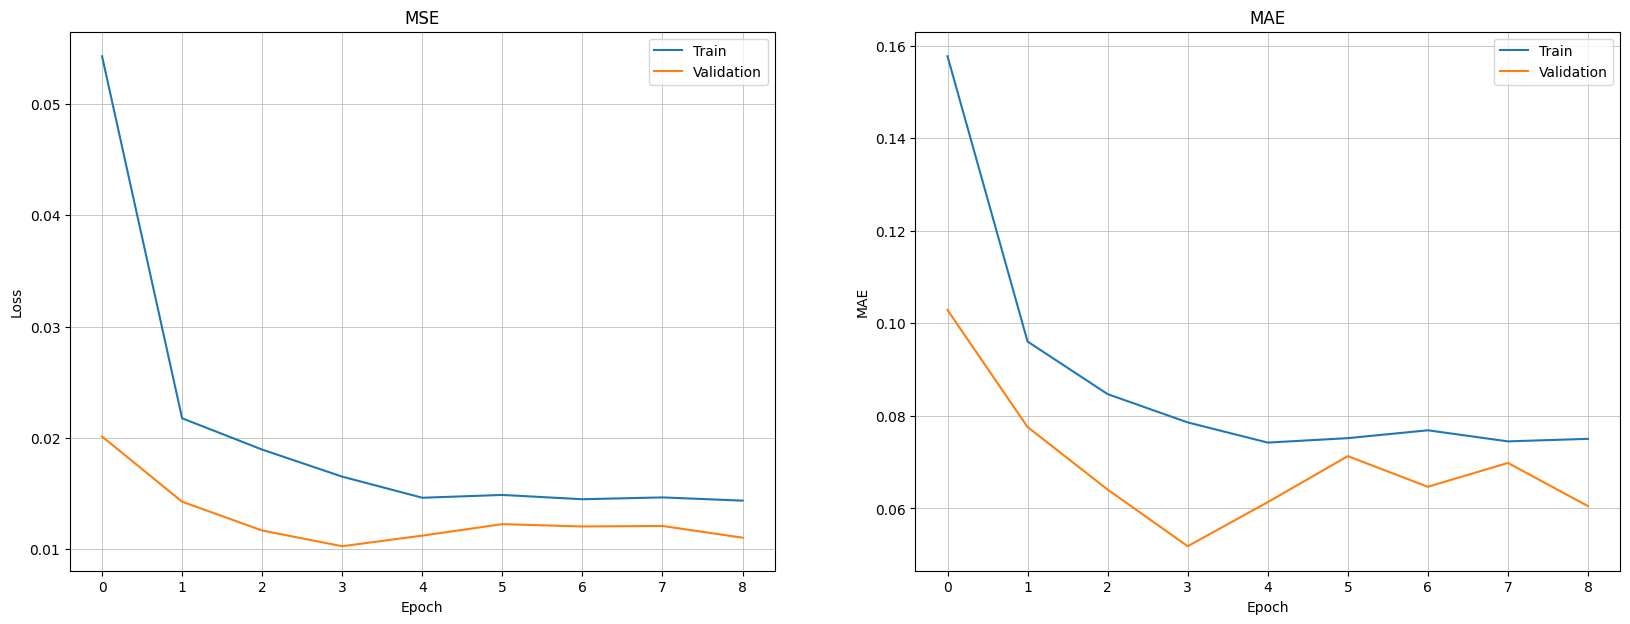

In [313]:
plot_history(history_8)

In [314]:
res8 = model_8.evaluate(X_test, y_test, verbose=0)
res8

[0.00196605222299695, 0.022797977551817894]

In [315]:
y_pred = model_8.predict(X_test)
y_pred

32/32 [==============================] - 0s 7ms/step


array([[0.29204667],
       [0.32925206],
       [0.2948689 ],
       [0.29445213],
       [0.2869402 ],
       [0.2774336 ],
       [0.2587976 ],
       [0.33076847],
       [0.3021512 ],
       [0.29577577],
       [0.28790137],
       [0.2877345 ],
       [0.2749558 ],
       [0.29968733],
       [0.29923236],
       [0.22641633],
       [0.3074933 ],
       [0.32890898],
       [0.29350883],
       [0.29978997],
       [0.28832793],
       [0.29518524],
       [0.32985944],
       [0.32730076],
       [0.02757433],
       [0.28509188],
       [0.29735595],
       [0.28808644],
       [0.32826546],
       [0.32998145],
       [0.2956239 ],
       [0.30147547],
       [0.3262689 ],
       [0.30147547],
       [0.28693238],
       [0.2930795 ],
       [0.30150503],
       [0.28737047],
       [0.29774117],
       [0.30566952],
       [0.30185714],
       [0.29284236],
       [0.26880753],
       [0.2988757 ],
       [0.289761  ],
       [0.2894555 ],
       [0.29225007],
       [0.285

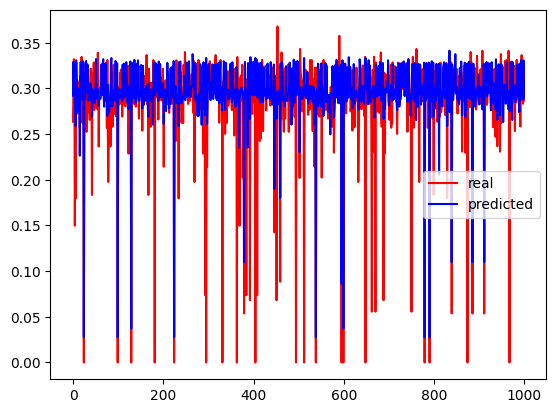

In [316]:
plot_predictions(y_test, y_pred)

In [317]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_unscaled = scaler_y.inverse_transform(y_pred)

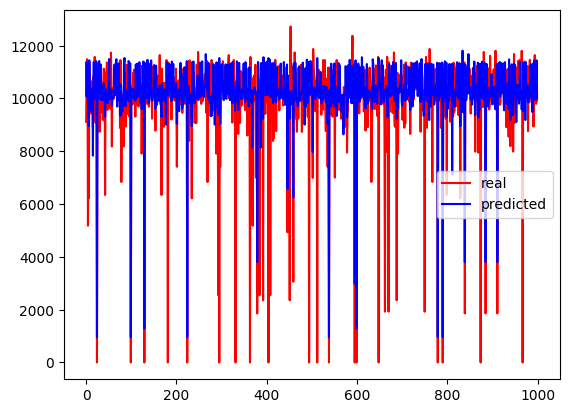

In [318]:
plot_predictions(y_test_unscaled, y_pred_unscaled)

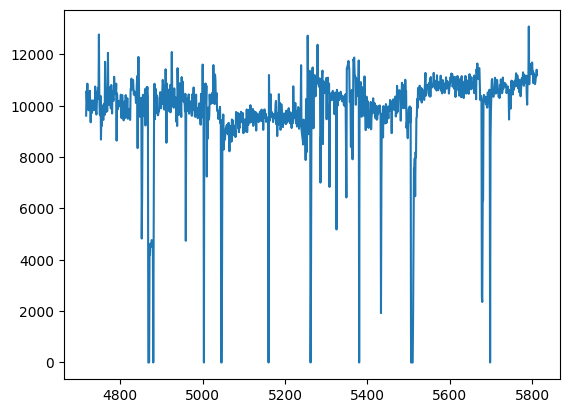

In [98]:
plt.plot(df_test['Qoil MPFM'])

#### Last model seems fine - change some parameters

In [403]:
new_features = ['Qoil MPFM', 'MPFM Venturi dP', 'WHT', 'Tubing Gradient']

In [404]:
def subsample_sequence(sequence, length, horizon):

    # Bounds of sampling
    last_possible = len(sequence) - length - horizon
    random_start = np.random.randint(0, last_possible)

    # Sample
    X = sequence.iloc[random_start:random_start + length, :][new_features]
    #iloc[random_start:random_start + length, :] 
    #[random_start:random_start +length].drop(columns=['Date','Qoil MPFM']) 
    y = sequence.iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #loc[random_start+length+horizon-1]['Qoil MPFM']

    return X, y


subsample_sequence(df_train, 3, 1)

(        Qoil MPFM  MPFM Venturi dP        WHT  Tubing Gradient
 107  42471.784454      1672.997986  51.905655              0.0
 108  42476.206977      1672.997986  51.889000              0.0
 109  42506.238674      1672.997986  51.872002              0.0,
 110    42079.322374
 Name: Qoil MPFM, dtype: float64)

In [405]:
def get_X_y(sequence, length, horizon, number_of_samples):
    
    X, y = [], []
    
    # Do as many samples as specified
    for sample in range(1,number_of_samples + 1):
    
        # Record sample X & y
        xi, yi = subsample_sequence(sequence, length, horizon)
        X.append(np.array(xi.values.T.tolist()).T) # Getting the right shape (sequences, observations,features)
        y.append(yi)

    return np.array(X), np.array(y)

In [406]:
X_train, y_train = get_X_y(sequence=df_train,
               length=500,
               horizon=1,
               number_of_samples=5000)

In [407]:
X_test, y_test = get_X_y(sequence=df_test,
               length=500,
               horizon=1,
               number_of_samples=1000)

In [408]:
scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))
X_train = scaler_X.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler_X.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1,y_train.shape[-1])).reshape(y_train.shape)
y_test = scaler_y.transform(y_test.reshape(-1,y_test.shape[1])).reshape(y_test.shape)

In [419]:
def init_model_9(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    #model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(normalizer)
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.LSTM(4, activation='tanh'))
    model.add(layers.Dropout(rate=0.2))
    #model.add(layers.LSTM(8, activation='tanh'))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [420]:
model_9 = init_model_9(X_train, y_train)
model_9.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 500, 8)            416       
                                                                 
 dropout_24 (Dropout)        (None, 500, 8)            0         
                                                                 
 lstm_26 (LSTM)              (None, 4)                 208       
                                                                 
 dropout_25 (Dropout)        (None, 4)                 0         
                                                                 
 dense_23 (Dense)            (None, 1)                 5         
                                                                 
Total params: 629
Trainable params: 629
Non-trainable params: 0
_________________________________________________________________


In [421]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [422]:
model_9, history_9 = fit_model(model_9)

Epoch 1/50
125/125 [==============================] - 9s 66ms/step - loss: 0.0418 - mae: 0.1444 - val_loss: 0.0124 - val_mae: 0.0717
Epoch 2/50
125/125 [==============================] - 8s 64ms/step - loss: 0.0181 - mae: 0.0889 - val_loss: 0.0099 - val_mae: 0.0505
Epoch 3/50
125/125 [==============================] - 8s 64ms/step - loss: 0.0158 - mae: 0.0792 - val_loss: 0.0098 - val_mae: 0.0526
Epoch 4/50
125/125 [==============================] - 8s 64ms/step - loss: 0.0157 - mae: 0.0799 - val_loss: 0.0099 - val_mae: 0.0531
Epoch 5/50
125/125 [==============================] - 8s 64ms/step - loss: 0.0153 - mae: 0.0774 - val_loss: 0.0097 - val_mae: 0.0481
Epoch 6/50
125/125 [==============================] - 8s 64ms/step - loss: 0.0150 - mae: 0.0761 - val_loss: 0.0107 - val_mae: 0.0542
Epoch 7/50
125/125 [==============================] - 8s 64ms/step - loss: 0.0142 - mae: 0.0716 - val_loss: 0.0094 - val_mae: 0.0460
Epoch 8/50
125/125 [==============================] - 8s 64ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

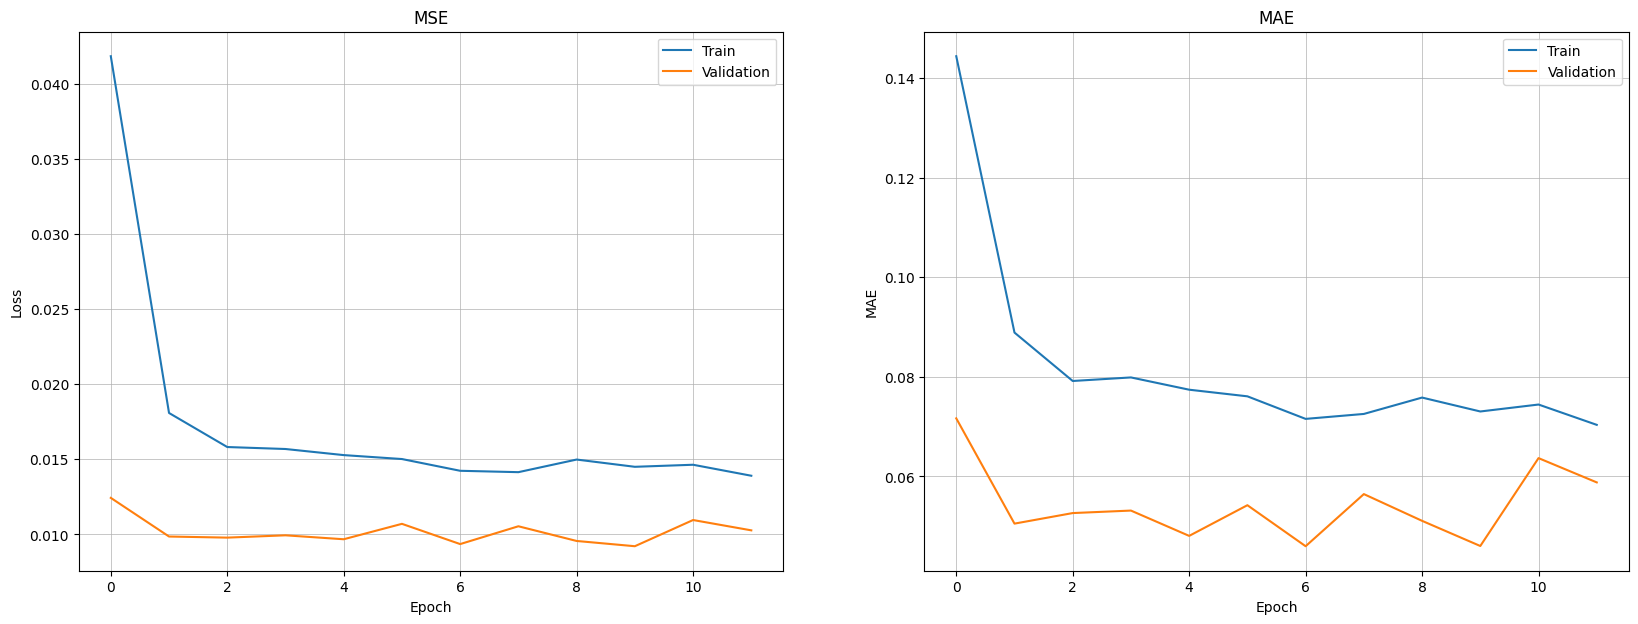

In [423]:
plot_history(history_9)

In [424]:
res9 = model_9.evaluate(X_test, y_test, verbose=0)
res9

[0.0016376208513975143, 0.01978853903710842]

In [425]:
y_pred = model_9.predict(X_test)
y_pred

32/32 [==============================] - 1s 14ms/step


array([[ 0.26925796],
       [ 0.29813474],
       [ 0.26221713],
       [ 0.29731244],
       [ 0.2866671 ],
       [ 0.29481322],
       [ 0.27945492],
       [ 0.25894713],
       [ 0.30839252],
       [ 0.30627725],
       [ 0.27506068],
       [ 0.32699758],
       [ 0.31174254],
       [ 0.30072874],
       [ 0.2994231 ],
       [ 0.2671016 ],
       [ 0.29077277],
       [ 0.2865973 ],
       [ 0.29846495],
       [ 0.30523205],
       [ 0.31216043],
       [ 0.30362007],
       [ 0.30384254],
       [ 0.3067587 ],
       [ 0.26266882],
       [ 0.3078489 ],
       [ 0.28423086],
       [ 0.30348986],
       [ 0.2836027 ],
       [ 0.30119732],
       [ 0.29794478],
       [ 0.24636313],
       [ 0.3078489 ],
       [ 0.31833708],
       [ 0.29640087],
       [ 0.265083  ],
       [ 0.2961433 ],
       [ 0.2681828 ],
       [ 0.31037083],
       [ 0.26418716],
       [ 0.30463493],
       [ 0.28170556],
       [ 0.31833708],
       [ 0.29852235],
       [ 0.30523205],
       [ 0

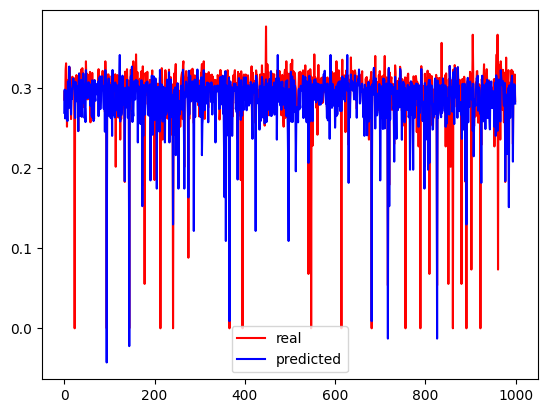

In [426]:
plot_predictions(y_test, y_pred)

In [427]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_unscaled = scaler_y.inverse_transform(y_pred)

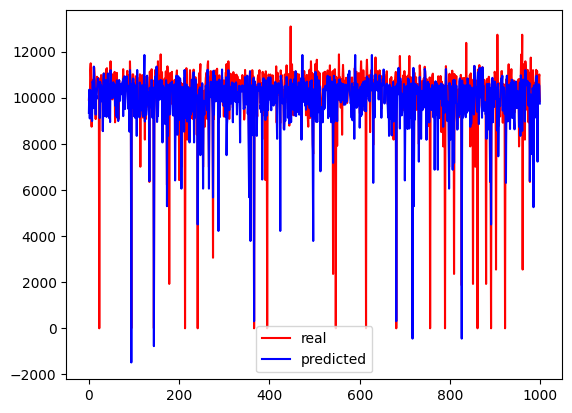

In [428]:
plot_predictions(y_test_unscaled, y_pred_unscaled)

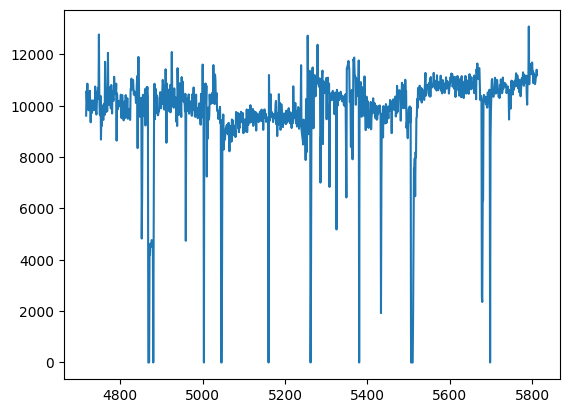

In [430]:
plt.plot(df_test['Qoil MPFM'])